In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
with open("first_database.pkl", "rb")as f:
    dataX,dataY=pickle.load(f)

In [4]:
# parameters
n = 100
m = 10
a = 5
sigma = 0.5
nu = 1.0

In [5]:
sel = list(range(n))
ind = np.random.choice(sel,m,replace=False)
x_selected = dataX[ind] # ids_M
ind

array([52, 26, 27,  2, 25,  3, 85,  8, 21, 63])

In [6]:
from kernel import kernel_matrix
Kmm = kernel_matrix(dataX, ind, ind)
Knm = kernel_matrix(dataX, sel, ind)

In [7]:
from graph_tools import *

In [8]:
sel_copy = np.arange(n)
np.random.shuffle(sel_copy)
agents = np.array_split(sel_copy, 5)

In [9]:
import networkx as nx

step_count = 10000

G = nx.complete_graph(a)
print(G.edges())

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [13]:
x_i = np.zeros((step_count+1, a, m))
lambda_ij = np.zeros((step_count+1, a, a, m))

learning_rate = [0.02]*step_count #np.array([0.01/k for k in range(1, step_count+1)])
Kim = [Knm[ids_agent,:] for ids_agent in agents]

for step in range(step_count):
    for agentId in range(a):
        A = sigma**2/5*Kmm + Kim[agentId].T@Kim[agentId] + nu/5*np.eye(m)
        b = Kim[agentId].T @ dataY[agents[agentId]]
        for (_, j) in G.edges(agentId):
            b -= lambda_ij[step, agentId, j, :] * (2*(agentId > j) - 1)
        x_i[step+1, agentId, :] = np.linalg.solve(A, b)
    for (i,j) in G.edges():
        k, l = min(i,j), max(i,j)
        lambda_ij[step+1, k, l, :] = \
        lambda_ij[step+1, l, k, :] = lambda_ij[step, l, k, :] + learning_rate[step]*(x_i[step+1, l, :] - x_i[step+1, k, :]) 

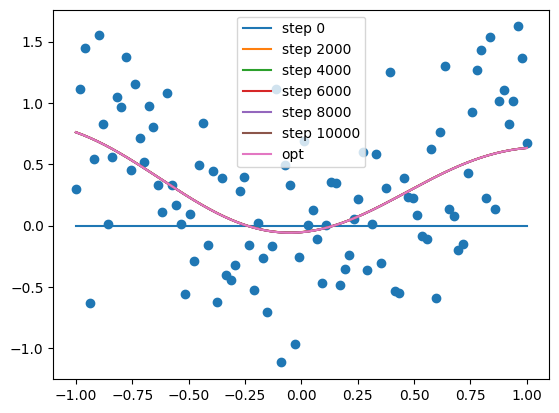

In [14]:
from kernel import calc_f, calc_alpha_opt

plt.scatter(dataX[sel], dataY[sel])
# for i in range(a):
    # plt.scatter(dataX[agents[i]], dataY[agents[i]], label="agent %d"%(i))


nt = 250
x_linspace = np.linspace(-1, 1, nt)
for s in range(0, step_count+1, step_count // 5):
    pred = [calc_f(dataX, ind, v, x_i[s, 0, :]) for v in x_linspace]
    plt.plot(x_linspace, pred, label="step %d" % s)

opt = [calc_f(dataX, ind, v, calc_alpha_opt(Kmm, Knm, dataY[:n])) for v in x_linspace]
plt.plot(x_linspace, opt, label="opt")

plt.legend()
plt.show()

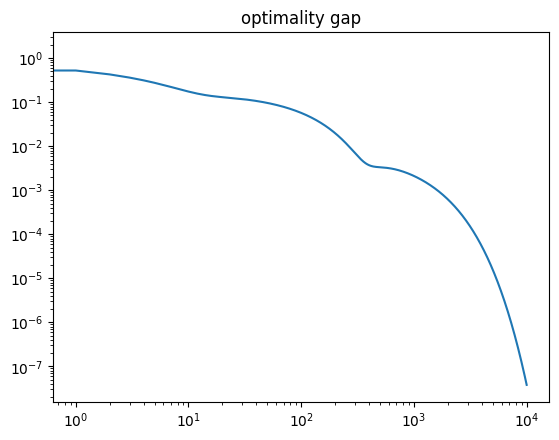

In [15]:
from kernel import plot_optimality_gap

plot_optimality_gap(Kmm, Knm, dataY[:n], x_i[:, 0, :])